In [51]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_msssim import SSIM, MS_SSIM
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [52]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"
# TODO: make sure to .to(device) the class later, and also set up gpu

# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0
# number of epochs
num_epochs = 40
# batch size for training
batch_size = 32
# height and width of input image
img_size = 64
# number of channels
nc0 = 1
nc1 = 4
nc2 = 8
nc3 = 16
# threshold
thresh = 0
# learning rate
lr = 0.002
# beta1 for Adam
beta1 = 0.5
# real label
real_label = 1.0
# fake label
fake_label = 0.0
# number of extra times to run the discriminator than the encdec per epoch
num_dis = 1
# coefficient of the discriminator loss in training
cof_dis = 9e-3

In [53]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [54]:
class FontDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.fontlist = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fontlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #c = chr(ord('A') + np.random.randint(0, 26))
        img_path1 = os.path.join(self.root_dir, "R/", f"{idx}.npy")
        img_path2 = os.path.join(self.root_dir, "A/", f"{idx}.npy")

        img1 = np.load(img_path1)
        img2 = np.load(img_path2)

        img1 = img1[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]
        img2 = img2[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        sample = {'c1': img1, 'c2': img2}

        return sample

In [55]:
# From https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/3
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=1)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter

In [57]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv1 = nn.Conv2d(nc0, nc1, 3, padding=1)
        self.conv1same = nn.Conv2d(nc1, nc1, 3, padding=1)
        self.conv2 = nn.Conv2d(nc1, nc2, 3, padding=1)
        self.conv3 = nn.Conv2d(nc2, nc2, 3, padding=1)
        self.conv2back = nn.Conv2d(nc2, nc1, 3, padding=1)
        self.conv1back = nn.Conv2d(nc1, nc0, 3, padding=1)
        
        self.conv1strided = nn.Conv2d(nc1, nc1, 3, stride=2, padding=1)
        self.conv2strided = nn.Conv2d(nc2, nc2, 3, stride=2, padding=1)

        self.deconv1 = nn.ConvTranspose2d(nc1, nc0, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(nc2, nc1, 3, padding=1)
        self.deconv1strided = nn.ConvTranspose2d(nc1, nc1, 3, stride=2, padding=1, output_padding=1)
        self.deconv2strided = nn.ConvTranspose2d(nc2, nc2, 3, stride=2, padding=1, output_padding=1)

        self.batchnorm0 = nn.BatchNorm2d(nc0)
        self.batchnorm1 = nn.BatchNorm2d(nc1)
        self.batchnorm2 = nn.BatchNorm2d(nc2)
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.threshold = nn.Threshold(thresh, 0)
        
        self.gaussian_filter = get_gaussian_kernel(kernel_size = 3, sigma=2, channels=nc1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.conv2(x)
        x = self.leakyrelu(x)
        x, idx1 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx2 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx3 = self.pool(x)
        
        x = self.unpool(x, idx3)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx2)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx1)
        x = self.conv2back(x)
        x = self.leakyrelu(x)
        
        x = self.gaussian_filter(x)
        x = self.conv1same(x)
        x = self.leakyrelu(x)
        x = self.conv1same(x)
        x = self.leakyrelu(x)
        
        x = self.conv1back(x)
        x = self.leakyrelu(x)
        
        x = self.tanh(x)
        
        return x

In [58]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            
            # 8 x img_size/4 x img_size/4
            nn.Conv2d(nc2, nc3, 4, stride=2, padding=1),
            nn.BatchNorm2d(nc3),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc3, nc3, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc3, nc3, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 16 x img_size/8 x img_size/8
            nn.Flatten(),
            nn.Linear(nc3 * img_size // 8 * img_size // 8, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [59]:
class LocalDiscriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 8 x img_size/4 x img_size/4
            nn.Flatten(),
            nn.Linear(nc2 * img_size // 4 * img_size // 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [60]:
lossD_list = []
loss_disc_list = []
loss_l1_list = []
loss_ssim_list = []
loss_local_list = []

In [61]:
def main():
    dataset = FontDataset(csv_file=fonts_csv, 
                        root_dir=dataroot, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(0.5, 0.5),
#                             AddGaussianNoise(0., 0.05),
                        ]))
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    
    encdec = EncoderDecoder()
    # use this line to continue training instead of starting a new one
    # encdec.load_state_dict(torch.load('encdec.pt'))
    
    criterionED_l1 = nn.L1Loss()
    criterionED_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=1)
    criterionED_ssim_local = SSIM(win_size=5, data_range=1, size_average=True, channel=1)
    optimizerED = optim.Adam(encdec.parameters(), lr=lr)

    disc = Discriminator()
    criterionD = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=lr)
    
    # training loop
    for epoch in range(num_epochs):
        running_lossD = 0.0
        running_loss_disc = 0.0
        running_loss_l1 = 0.0
        running_loss_ssim = 0.0
        running_loss_local = 0.0
        
        for it in range(num_dis):
            for i, data in enumerate(dataloader):
                disc.zero_grad()
                
                b_size = data['c2'].size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                
                outputD = disc(data['c2']).view(-1)
                lossD_real = criterionD(outputD, label)
                lossD_real.backward()

                # all fake batch
                outputED = encdec(data['c1'])
                label.fill_(fake_label)
                outputD = disc(outputED.detach()).view(-1)
                lossD_fake = criterionD(outputD, label)
                lossD_fake.backward()

                lossD = lossD_real + lossD_fake
                optimizerD.step()

        for i, data in enumerate(dataloader):
            ###########################
            # update disc
            ###########################
            disc.zero_grad()
            # all real batch
            b_size = data['c2'].size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            outputD = disc(data['c2']).view(-1)
            lossD_real = criterionD(outputD, label)
            lossD_real.backward()
            
            # all fake batch
            outputED = encdec(data['c1'])
            
            
            label.fill_(fake_label)
            outputD = disc(outputED.detach()).view(-1)
            lossD_fake = criterionD(outputD, label)
            lossD_fake.backward()

            lossD = lossD_real + lossD_fake
            optimizerD.step()

            ###########################
            # update encdec
            ###########################
            encdec.zero_grad()
            # rerun disc
            label.fill_(real_label)
            outputD = disc(outputED).view(-1)
            lossED_disc = criterionD(outputD, label)
            # run encdec
            lossED_l1 = criterionED_l1(outputED, data['c2'])
            lossED_local = 0.0
            for _ in range(3):
                x = np.random.randint(16, 48)
                y = np.random.randint(16, 48)
                outputED_patch = outputED[:, :, x-8:x+8, y-8:y+8]
                datac2_patch = data['c2'][:, :, x-8:x+8, y-8:y+8]
                lossED_local += criterionED_l1(outputED_patch, datac2_patch)
            outputED_norm = (outputED + 1) / 2
            datac2_norm = (data['c2'] + 1) / 2
            lossED_ssim = 1 - criterionED_ssim(outputED_norm, datac2_norm)

            lossED = cof_dis * lossED_disc + 0.16 * lossED_l1 + 0.84 * lossED_ssim + lossED_local / 3
            lossED.backward()
            optimizerED.step()
    
            running_lossD += lossD.item()
            running_loss_disc += lossED_disc.item()
            running_loss_l1 += lossED_l1.item()
            running_loss_ssim += lossED_ssim.item()
            running_loss_local += lossED_local.item() / 3
            if i % 50 == 49:
                print(f"Epoch {epoch+1}, Iteration {i+1}, Loss D {running_lossD}, Loss Disc {running_loss_disc}, Loss L1 {running_loss_l1}, Loss SSIM {running_loss_ssim}, Loss Local {running_loss_local}")
                lossD_list.append(running_lossD)
                loss_disc_list.append(running_loss_disc)
                loss_l1_list.append(running_loss_l1)
                loss_ssim_list.append(running_loss_ssim)
                loss_local_list.append(running_loss_local)
                running_lossD = 0.0
                running_loss_disc = 0.0
                running_loss_l1 = 0.0
                running_loss_ssim = 0.0
                running_loss_local = 0.0
                
                fig = plt.figure(figsize=(8, 8))
                fig.add_subplot(1, 2, 1)
                plt.imshow(data['c1'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                fig.add_subplot(1, 2, 2)
                plt.imshow(outputED[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                plt.show()
    
    torch.save(encdec.state_dict(), 'encdecxd.pt')
    print("Done")

Epoch 1, Iteration 50, Loss D 17.11802038607944, Loss Disc 743.7267297804356, Loss L1 42.15975493192673, Loss SSIM 34.53316581249237, Loss Local 43.543680111567184


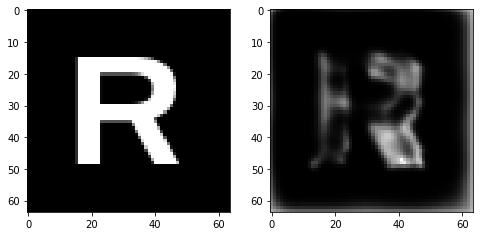

Epoch 1, Iteration 100, Loss D 53.08533784747124, Loss Disc 91.15547668933868, Loss L1 9.80189773440361, Loss SSIM 19.025364935398102, Loss Local 29.528306722640984


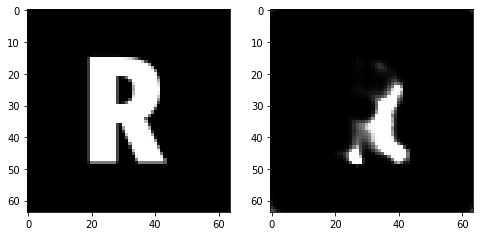

Epoch 2, Iteration 50, Loss D 14.601502507925034, Loss Disc 201.96252536773682, Loss L1 8.127216339111328, Loss SSIM 14.244165241718292, Loss Local 25.43663136164347


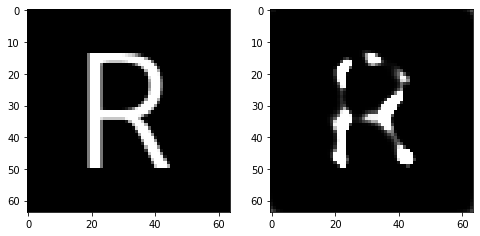

Epoch 2, Iteration 100, Loss D 12.863967396318913, Loss Disc 224.82230710983276, Loss L1 7.524399235844612, Loss SSIM 13.642143666744232, Loss Local 24.169100622336064


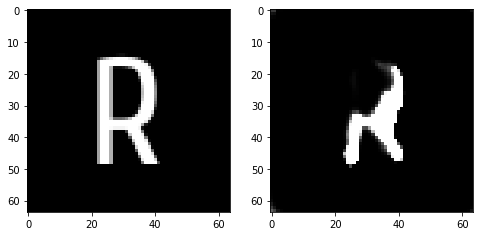

Epoch 3, Iteration 50, Loss D 3.850194155238569, Loss Disc 372.7258644104004, Loss L1 7.012966096401215, Loss SSIM 13.181584239006042, Loss Local 20.69306596120198


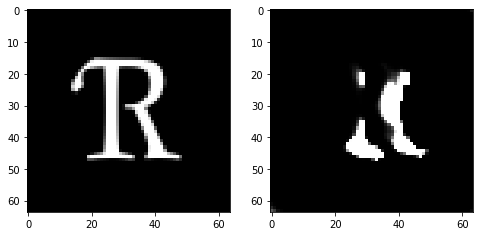

Epoch 3, Iteration 100, Loss D 2.453158470802009, Loss Disc 400.5411276817322, Loss L1 6.807432994246483, Loss SSIM 12.963381826877594, Loss Local 21.23672876755397


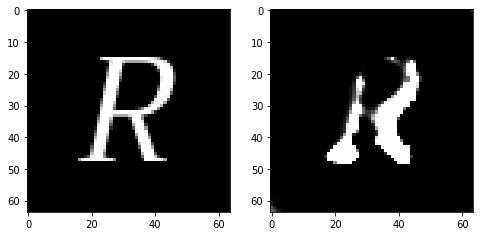

Epoch 4, Iteration 50, Loss D 3.714710336877033, Loss Disc 469.5324501991272, Loss L1 6.573579296469688, Loss SSIM 11.989677667617798, Loss Local 20.803421358267464


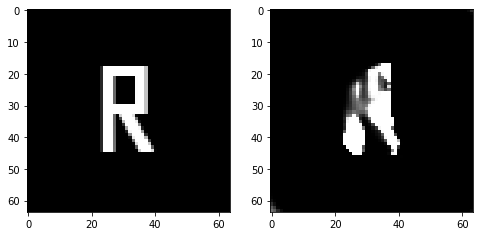

Epoch 4, Iteration 100, Loss D 0.6955015000421554, Loss Disc 422.9334235191345, Loss L1 6.436858281493187, Loss SSIM 11.107915937900543, Loss Local 18.576552013556167


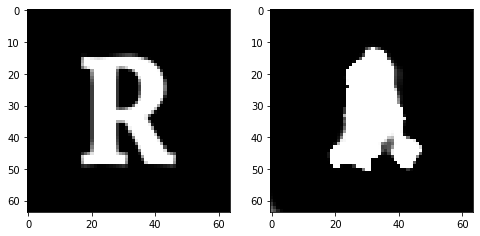

Epoch 5, Iteration 50, Loss D 0.17152395217271987, Loss Disc 480.358115196228, Loss L1 6.422619879245758, Loss SSIM 10.777017652988434, Loss Local 21.166506747404735


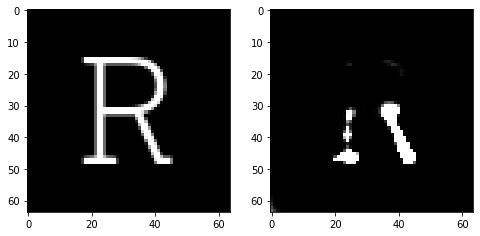

Epoch 5, Iteration 100, Loss D 4.6412702115485445, Loss Disc 428.27134346961975, Loss L1 6.487309128046036, Loss SSIM 10.630117058753967, Loss Local 19.961162279049557


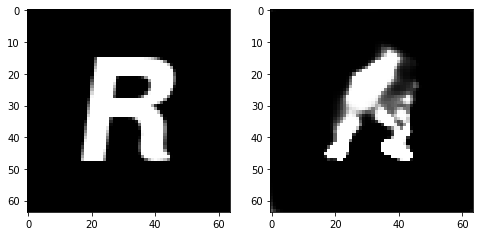

Epoch 6, Iteration 50, Loss D 0.1964670971938176, Loss Disc 433.46315145492554, Loss L1 6.178399205207825, Loss SSIM 9.908359110355377, Loss Local 20.071134239435196


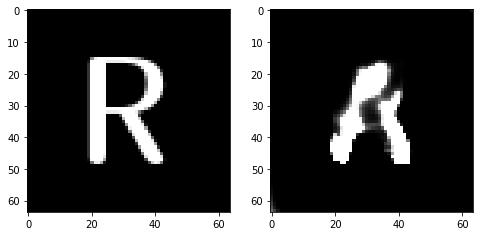

Epoch 6, Iteration 100, Loss D 24.41531945182942, Loss Disc 349.1942566335201, Loss L1 6.121412009000778, Loss SSIM 9.980309903621674, Loss Local 20.261102398236595


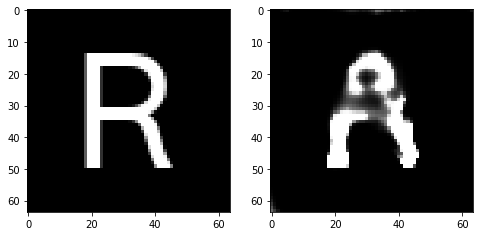

Epoch 7, Iteration 50, Loss D 2.319433789467439, Loss Disc 349.09954142570496, Loss L1 6.03317105025053, Loss SSIM 9.72326409816742, Loss Local 19.859247326850884


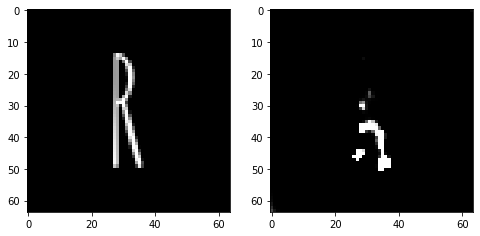

Epoch 7, Iteration 100, Loss D 12.146119949175045, Loss Disc 338.06842839717865, Loss L1 6.010058209300041, Loss SSIM 9.51702356338501, Loss Local 18.786169032255806


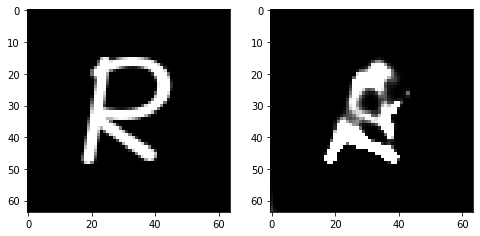

Epoch 8, Iteration 50, Loss D 3.3321241124067456, Loss Disc 344.4430642127991, Loss L1 5.854098096489906, Loss SSIM 9.483781278133392, Loss Local 17.765402277310688


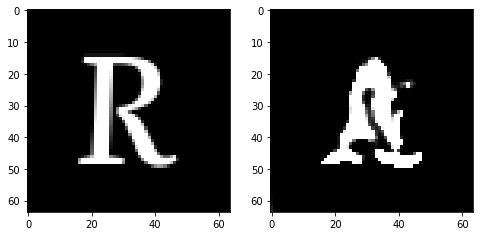

Epoch 8, Iteration 100, Loss D 0.7779907952062786, Loss Disc 367.46894550323486, Loss L1 5.725390046834946, Loss SSIM 9.13518363237381, Loss Local 17.289713044961296


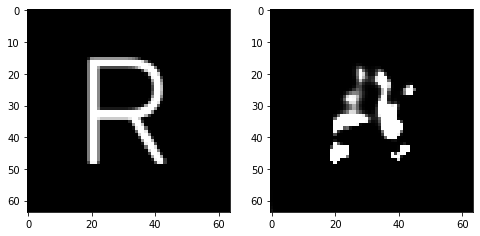

Epoch 9, Iteration 50, Loss D 0.5244607953063678, Loss Disc 444.05078649520874, Loss L1 5.62569023668766, Loss SSIM 8.852681934833527, Loss Local 17.73295430342357


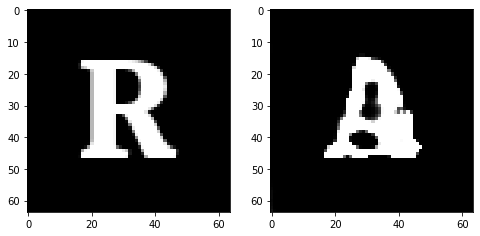

Epoch 9, Iteration 100, Loss D 2.5385373468743637, Loss Disc 386.11863899230957, Loss L1 5.429940164089203, Loss SSIM 8.502088725566864, Loss Local 15.697077910105387


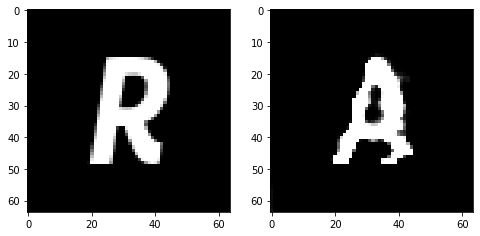

Epoch 10, Iteration 50, Loss D 10.493437940254807, Loss Disc 247.06859421730042, Loss L1 5.237242452800274, Loss SSIM 7.867587447166443, Loss Local 15.867459982633592


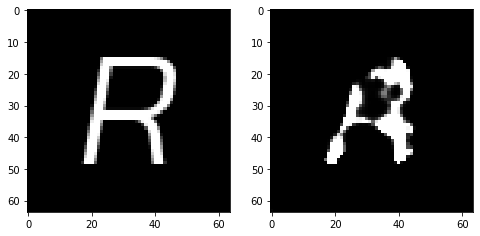

Epoch 10, Iteration 100, Loss D 1.5616802086587995, Loss Disc 333.70590019226074, Loss L1 5.405317470431328, Loss SSIM 8.306359350681305, Loss Local 17.118763377269108


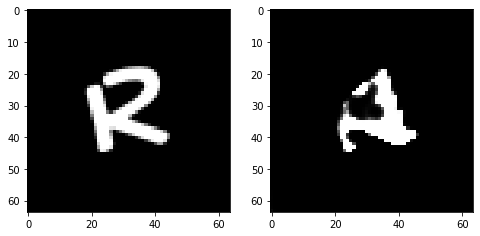

Epoch 11, Iteration 50, Loss D 1.51859358191723, Loss Disc 380.4924030303955, Loss L1 5.297240294516087, Loss SSIM 8.032606363296509, Loss Local 16.574588278929394


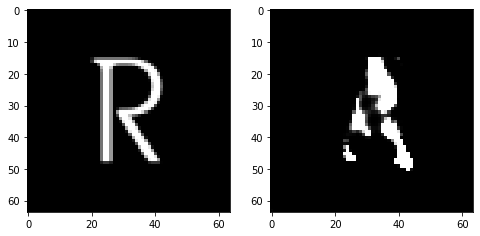

Epoch 11, Iteration 100, Loss D 6.098371108761057, Loss Disc 359.2943482398987, Loss L1 5.328130967915058, Loss SSIM 8.128649413585663, Loss Local 17.217072288195297


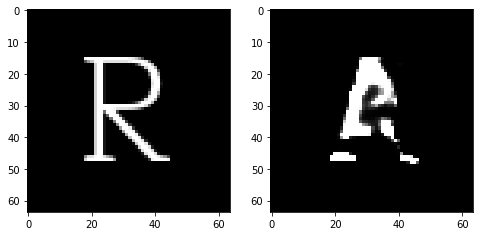

In [ ]:
main()

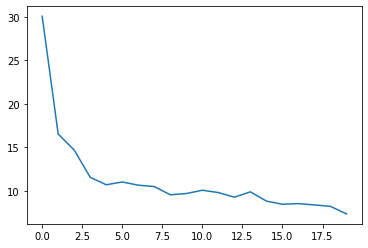

In [25]:
# plot losses
plt.plot(loss_ssim_list)
plt.show()

In [148]:
# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0

dataset = FontDataset(csv_file=fonts_csv, 
                      root_dir=dataroot, 
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(0.5, 0.5),
                      ]))

In [149]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=workers)

encdec = EncoderDecoder()
encdec.load_state_dict(torch.load('encdec-Copy1.pt'))
encdec.eval()

EncoderDecoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1same): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2back): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1back): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1strided): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2strided): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1strided): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2strided): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(

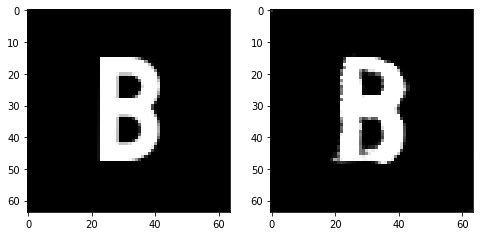

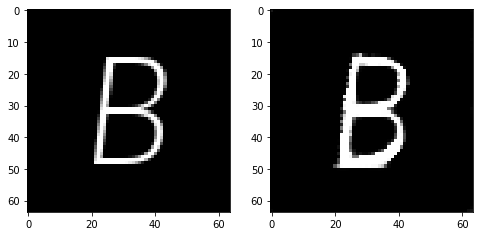

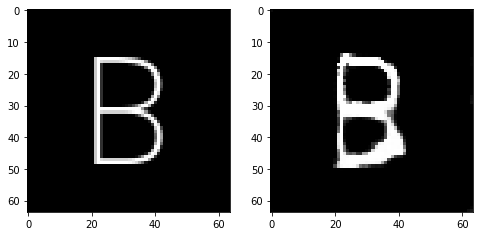

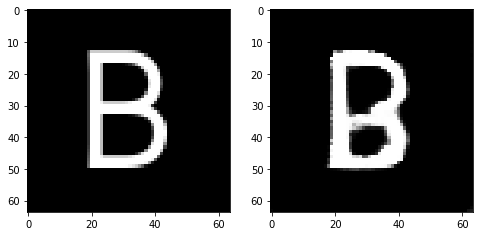

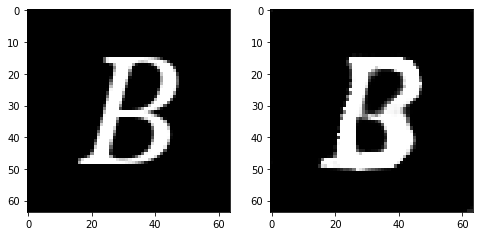

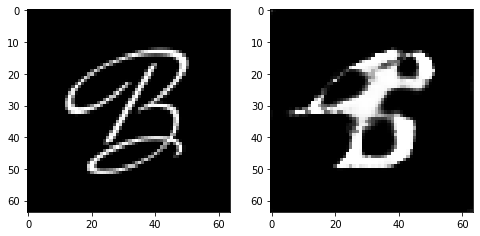

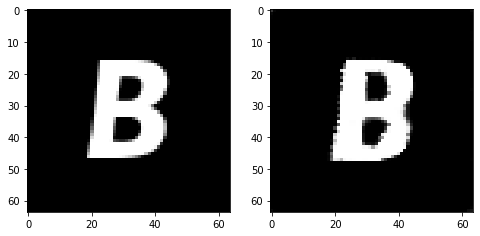

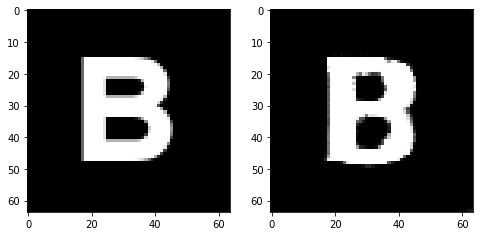

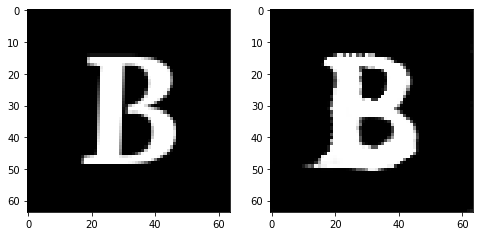

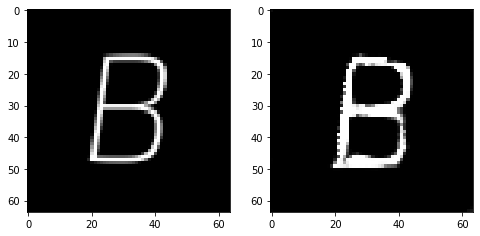

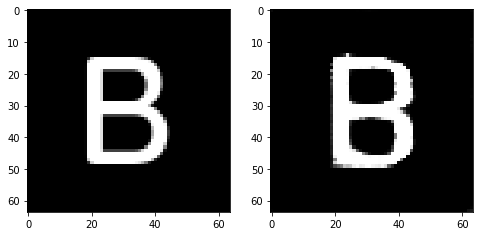

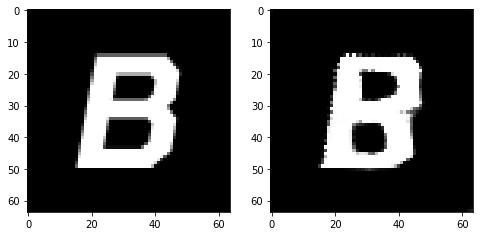

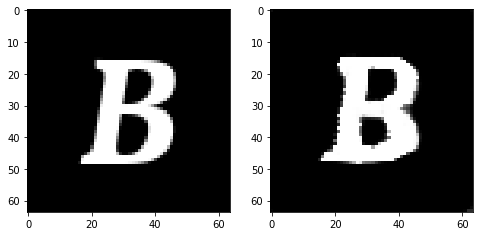

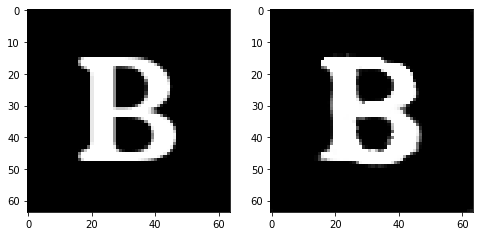

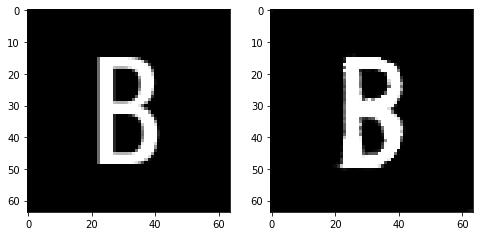

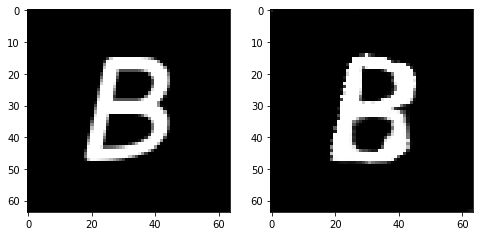

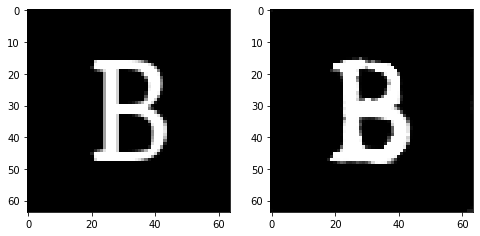

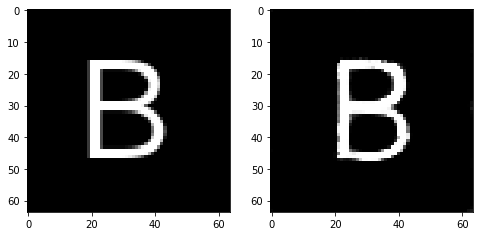

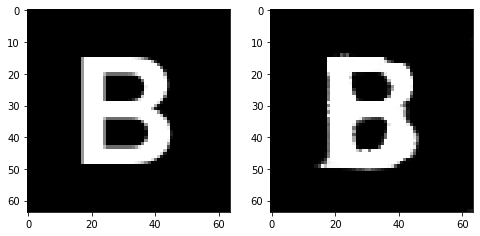

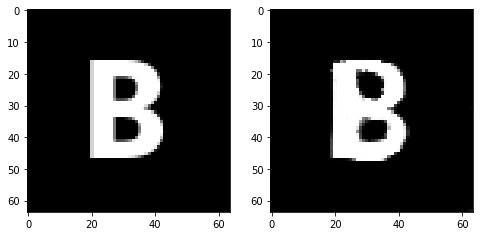

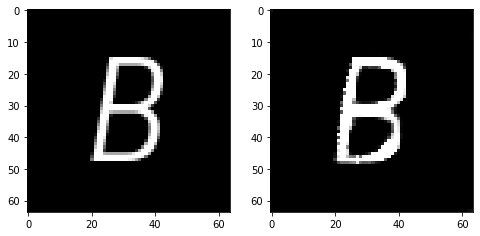

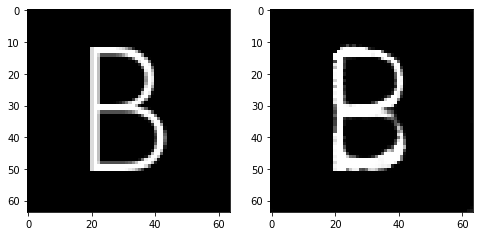

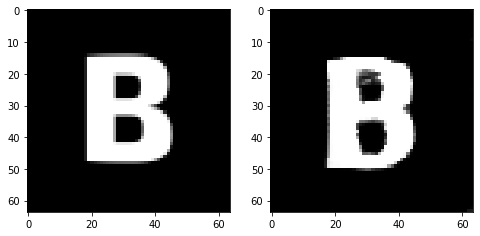

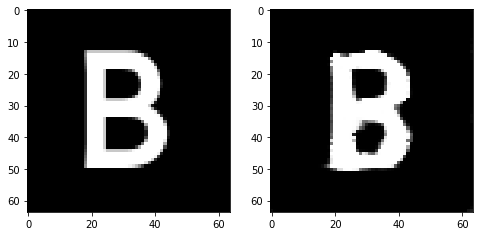

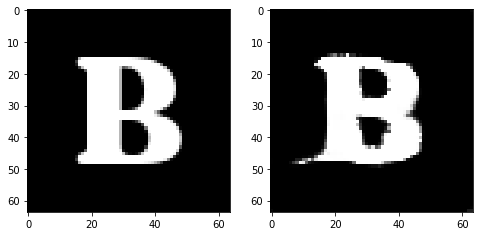

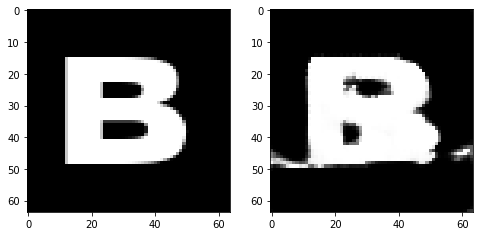

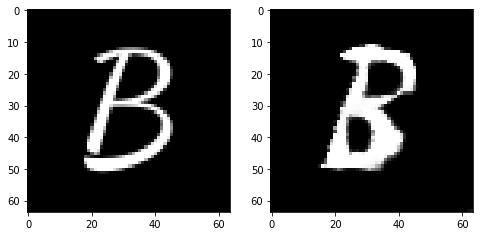

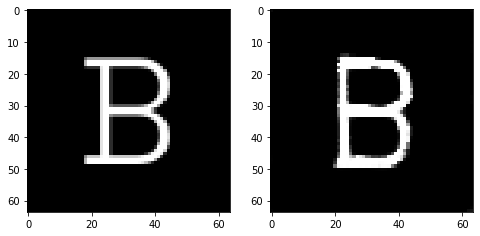

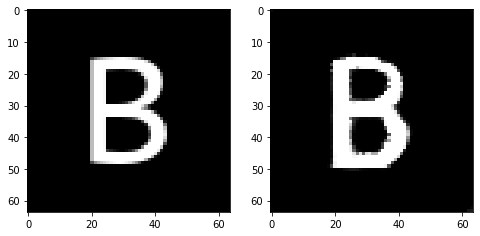

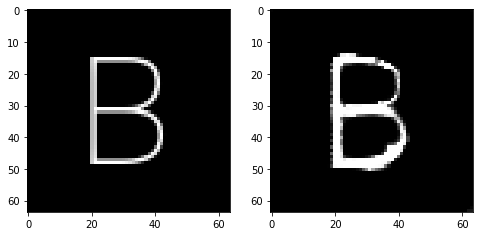

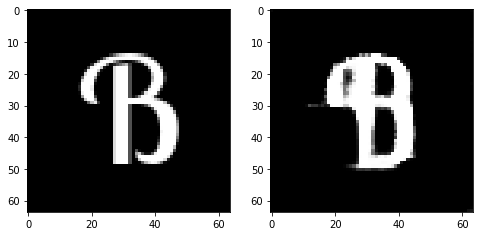

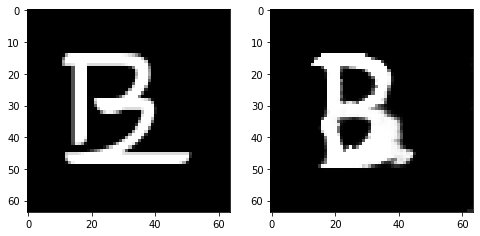

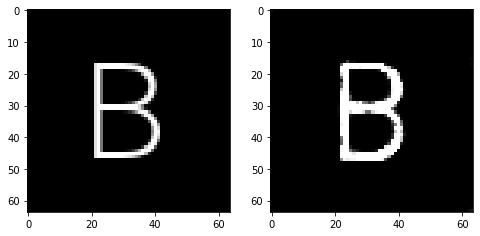

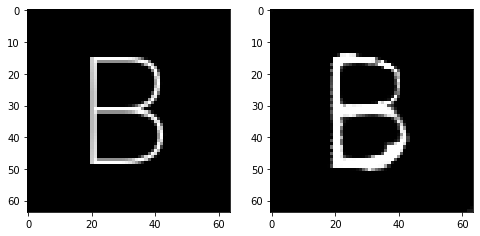

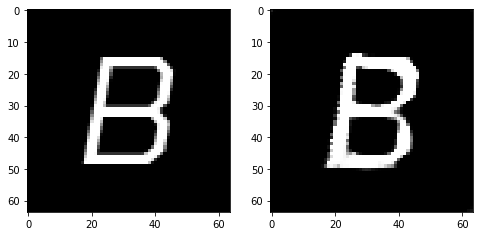

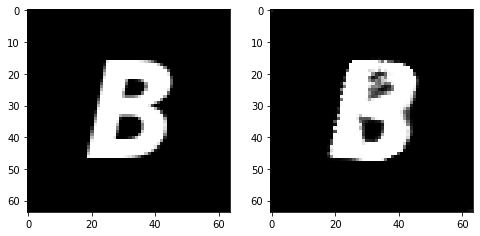

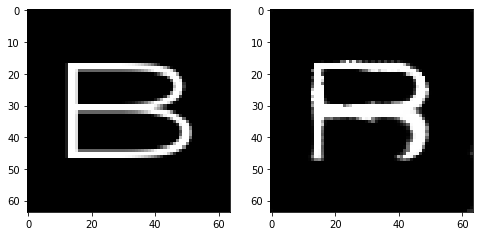

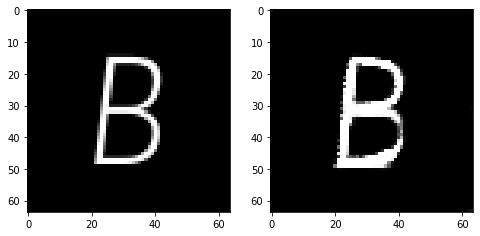

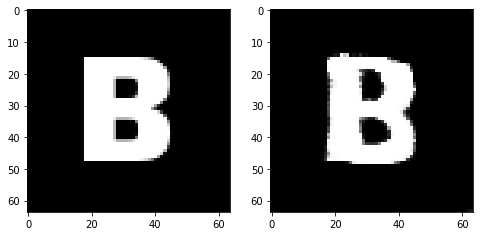

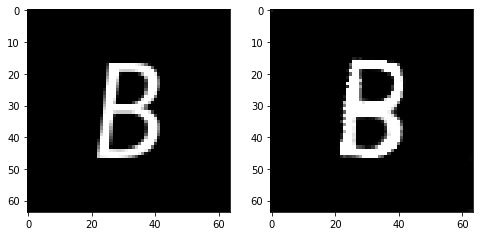

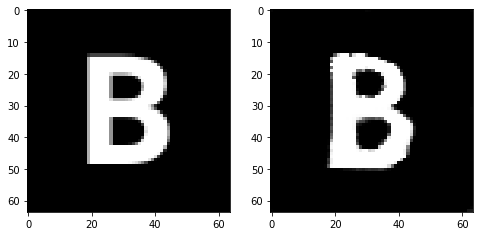

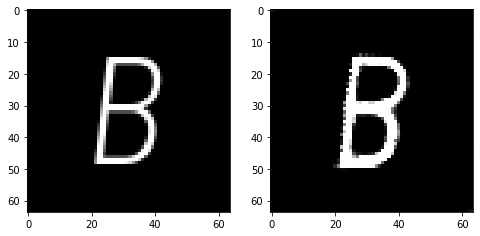

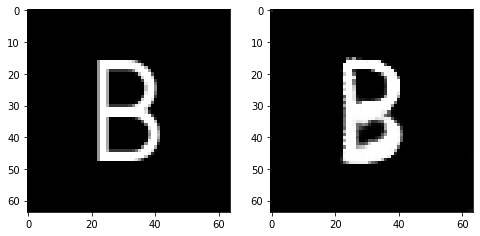

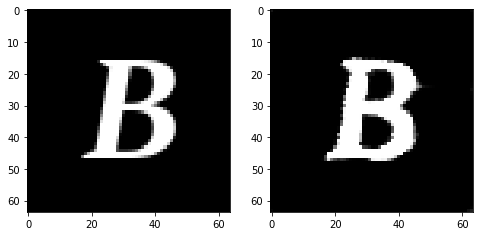

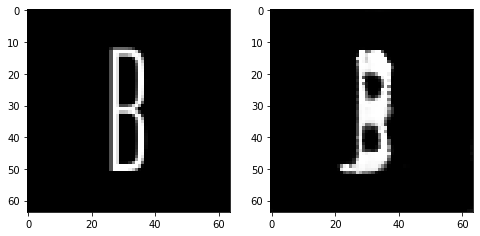

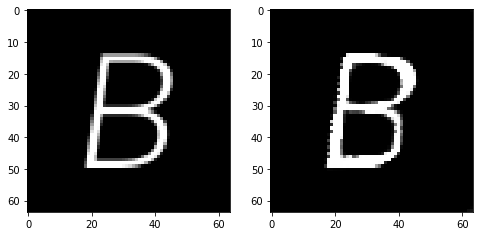

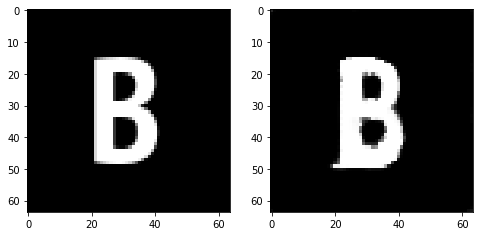

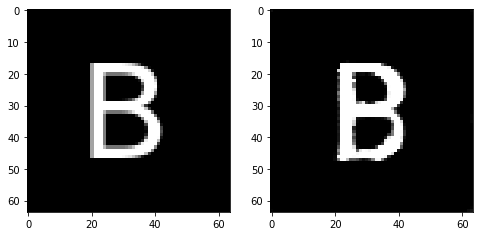

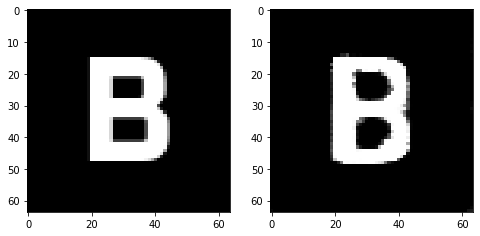

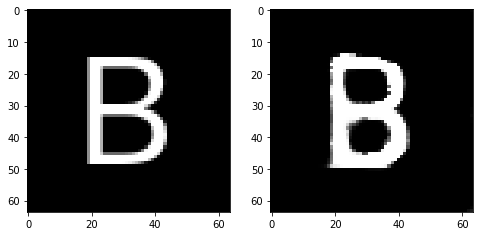

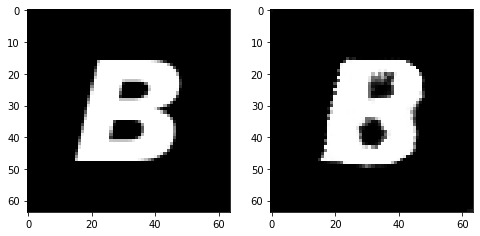

In [150]:
for i, data in enumerate(dataloader):
    if i > 50:
        break
    fig = plt.figure(figsize=(8, 8))
    output = encdec(data['c1'])
    fig.add_subplot(1, 2, 1)
    plt.imshow(data['c2'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(output[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.show()

In [26]:
font_set = pd.read_csv('fonts.csv', sep=' ', header=None)

letter_dir = './images/B'
for file in os.listdir(letter_dir):
    print(file)
    img = np.load(os.path.join(letter_dir, file))
    
    num = int(file.split('.')[0])
    font_name = font_set[1][num]
    print(font_name)
    
    plt.imshow(img, cmap='gray')
    plt.show()